<a href="https://colab.research.google.com/github/TerryHilario/TerryHilario/blob/main/bbca_of_SARIMA_Stock_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title
!pip install fbprophet
!pip install -U statsmodels
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 5.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from scipy import stats 
from statsmodels.graphics.gofplots import qqplot as qq
from scipy.stats import kurtosis
import scipy
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.core.window.rolling import Rolling
from sklearn.model_selection import train_test_split as split
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import warnings
import itertools
warnings.filterwarnings("ignore")
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, TimeSeriesSplit
from fbprophet import Prophet
from IPython import display
from matplotlib import pyplot
import os
import re
from colorama import Fore, Back, Style
import seaborn as sns
import plotly.express as px
import warnings
from matplotlib.patches import Patch
##Matplotlib Parameters
import matplotlib.ticker as ticker
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
plt.style.context('fivethirtyeight')

In [ ]:
data = pd.read_csv('/content/BBCA.JK Jan 15- jan 18.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       767 non-null    object 
 1   Open       767 non-null    float64
 2   High       767 non-null    float64
 3   Low        767 non-null    float64
 4   Close      767 non-null    float64
 5   Adj Close  767 non-null    float64
 6   Volume     767 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 42.1+ KB


In [ ]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,767.000000,767.000000,767.000000,767.000000,767.000000,7.670000e+02
mean,3100.651890,3127.601043,3075.176010,3100.788787,2873.636533,8.115587e+07
std,557.532474,558.957774,552.788447,556.974820,545.567974,5.988201e+07
min,2275.000000,2350.000000,2200.000000,2260.000000,2067.410645,0.000000e+00
25%,2655.000000,2680.000000,2630.000000,2655.000000,2435.719971,5.130200e+07
50%,2930.000000,2960.000000,2900.000000,2935.000000,2708.293457,7.007000e+07
75%,3500.000000,3537.500000,3460.000000,3500.000000,3281.309204,1.011925e+08
max,4560.000000,4690.000000,4530.000000,4560.000000,4292.082520,1.062862e+09


In [ ]:
data['Date'] = pd.to_datetime(data['Date'],format='%Y-%m-%d')
data.set_index('Date',inplace=True)
data['Date'] = data.index

In [ ]:
data_feature_selected = data.drop(axis=1,labels=['Open','High','Low','Close','Volume'])

In [ ]:
col_order = ['Date','Adj Close']
data_feature_selected = data_feature_selected.reindex(columns=col_order)
data_feature_selected 

,Date,Adj Close
Date,,
2015-01-02,2015-01-02,2403.688232
2015-01-05,2015-01-05,2399.144287
2015-01-06,2015-01-06,2380.968994
2015-01-07,2015-01-07,2385.513184
2015-01-08,2015-01-08,2358.250000
...,...,...
2018-01-24,2018-01-24,4249.727539
2018-01-25,2018-01-25,4249.727539
2018-01-26,2018-01-26,4273.257324


In [ ]:
data_feature_selected = data_feature_selected.rename(columns = {"Date":"ds", "Adj Close":"y"})
data_feature_selected

,ds,y
Date,,
2015-01-02,2015-01-02,2403.688232
2015-01-05,2015-01-05,2399.144287
2015-01-06,2015-01-06,2380.968994
2015-01-07,2015-01-07,2385.513184
2015-01-08,2015-01-08,2358.250000
...,...,...
2018-01-24,2018-01-24,4249.727539
2018-01-25,2018-01-25,4249.727539
2018-01-26,2018-01-26,4273.257324


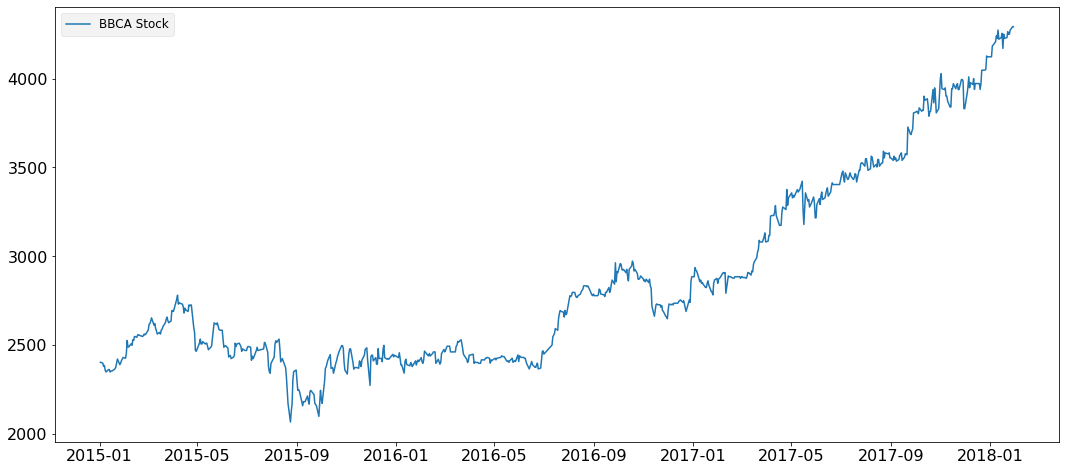

In [ ]:

fig = plt.figure(figsize=(18,8))
plt.plot(data_feature_selected ['y'],label='BBCA Stock')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.style.use('fivethirtyeight')
plt.legend(prop={'size': 12})
plt.show()

In [ ]:
data_feature_selected
data_feature_selected.index


DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-22',
               '2018-01-23', '2018-01-24', '2018-01-25', '2018-01-26',
               '2018-01-29', '2018-01-30'],
              dtype='datetime64[ns]', name='Date', length=767, freq=None)

In [ ]:
data_feature_selected

,ds,y
Date,,
2015-01-02,2015-01-02,2403.688232
2015-01-05,2015-01-05,2399.144287
2015-01-06,2015-01-06,2380.968994
2015-01-07,2015-01-07,2385.513184
2015-01-08,2015-01-08,2358.250000
...,...,...
2018-01-24,2018-01-24,4249.727539
2018-01-25,2018-01-25,4249.727539
2018-01-26,2018-01-26,4273.257324


In [ ]:
data_feature_selected[0:745]

,ds,y
Date,,
2015-01-02,2015-01-02,2403.688232
2015-01-05,2015-01-05,2399.144287
2015-01-06,2015-01-06,2380.968994
2015-01-07,2015-01-07,2385.513184
2015-01-08,2015-01-08,2358.250000
...,...,...
2017-12-25,2017-12-25,4047.359375
2017-12-26,2017-12-26,4047.359375
2017-12-27,2017-12-27,4052.065186


In [ ]:
def ad_fuller_func(X):
  result_ad_fuller = adfuller(X)
  print('ADF Statistic: %f' % result_ad_fuller[0])
  print('p-value: %f' %result_ad_fuller[1])
  print('Critical Values:')
  for key, value in result_ad_fuller[4].items():
	  print('\t%s: %.3f' % (key, value))
 
  if result_ad_fuller[0] < result_ad_fuller[4]['5%']:
    print('Reject Null Hypothesis(Ho)-Time Series is Stationary')
  else:
    print('Failed to Reject Ho-Time Series is Non-Stationary')

In [ ]:
ad_fuller_func(data_feature_selected['y'])

ADF Statistic: 1.612539
p-value: 0.997895
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Failed to Reject Ho-Time Series is Non-Stationary


In [ ]:
data_diff = data_feature_selected['y'] - data_feature_selected['y'].shift(1)

In [ ]:
data_diff

Date
2015-01-02          NaN
2015-01-05    -4.543945
2015-01-06   -18.175293
2015-01-07     4.544190
2015-01-08   -27.263184
                ...    
2018-01-24   -14.118164
2018-01-25     0.000000
2018-01-26    23.529785
2018-01-29    18.825196
2018-01-30     0.000000
Name: y, Length: 767, dtype: float64

In [ ]:
ad_fuller_func(data_diff[1:])

ADF Statistic: -13.462450
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Reject Null Hypothesis(Ho)-Time Series is Stationary


In [ ]:
train = data_diff[1:745]
train

Date
2015-01-05    -4.543945
2015-01-06   -18.175293
2015-01-07     4.544190
2015-01-08   -27.263184
2015-01-09    -9.088135
                ...    
2017-12-25     0.000000
2017-12-26     0.000000
2017-12-27     4.705811
2017-12-28    75.299560
2017-12-29    -4.705566
Name: y, Length: 744, dtype: float64

In [ ]:
test = data_diff[745:]
test

Date
2018-01-01     0.000000
2018-01-02     0.000000
2018-01-03     0.000000
2018-01-04    61.180664
2018-01-05     4.706543
2018-01-08    18.824218
2018-01-09    32.943360
2018-01-10   -14.117676
2018-01-11    47.061035
2018-01-12   -51.768066
2018-01-15     9.413086
2018-01-16    23.531250
2018-01-17   -84.712403
2018-01-18    80.006348
2018-01-19   -23.531250
2018-01-22     4.706055
2018-01-23    32.943359
2018-01-24   -14.118164
2018-01-25     0.000000
2018-01-26    23.529785
2018-01-29    18.825196
2018-01-30     0.000000
Name: y, dtype: float64

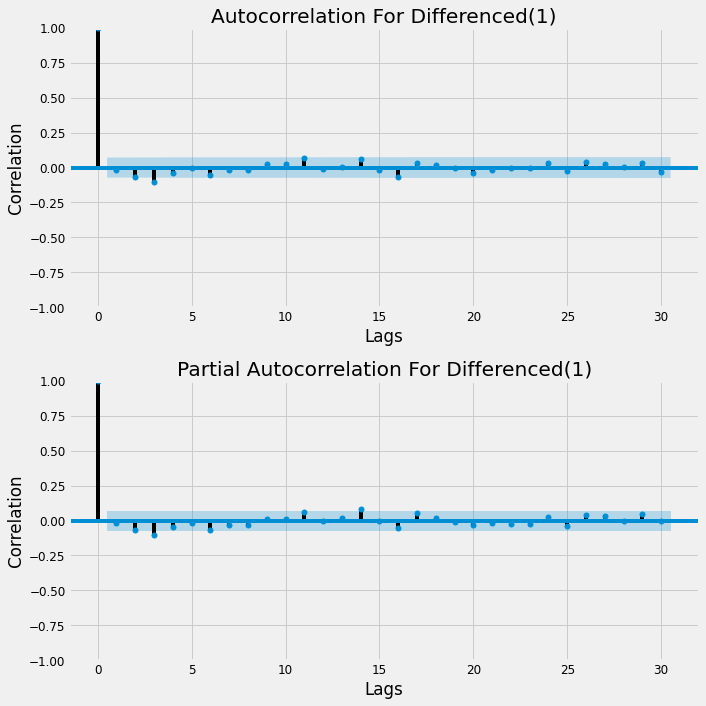

In [ ]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(10,10))
acf = plot_acf(train,lags=30,ax=ax1)
pacf = plot_pacf(train,lags=30,ax=ax2)
ax1.set_title('Autocorrelation For Differenced(1)')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_title('Partial Autocorrelation For Differenced(1)')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')
plt.tight_layout(pad=1)

In [ ]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of grid search Model parameter combinations for Seasonal-ARIMA')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))

Examples of grid search Model parameter combinations for Seasonal-ARIMA
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)


In [ ]:
list_param = []
list_param_seasonal=[]
list_results_aic=[]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = model.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            list_param.append(param)
            list_param_seasonal.append(param_seasonal)
            list_results_aic.append(results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7434.223595543906
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:7326.730735127281
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:7211.712167165668
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:7830.051785757092
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:7244.90141571193
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:7134.312713673546
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:8506.195609805029
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:7631.426816436857
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:7097.099471181754
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:7335.816486529273
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:7328.678607768636
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:7213.6793700591525
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:7484.716833904196
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:7246.753465786229
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:7134.462979855757
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:7925.760410999772
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:7412.067201714928
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:7099.019313516768
ARIMA(0, 0

In [ ]:
#ARIMA(1, 0, 2)x(0, 2, 2, 12)12 - AIC:7070.135314638718

In [ ]:
  model = sm.tsa.statespace.SARIMAX(train,
                                            order=(1, 0, 2),
                                            seasonal_order=(0, 2, 2, 12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
  model_aic = model.fit()
  print(model_aic.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5639      0.155      3.638      0.000       0.260       0.868
ma.L1         -1.2588      0.172     -7.314      0.000      -1.596      -0.921
ma.L2         -0.1549      0.106     -1.464      0.143      -0.362       0.052
ma.S.L12      -1.9974     20.470     -0.098      0.922     -42.117      38.122
ma.S.L24       1.0001     20.501      0.049      0.961     -39.182      41.182
sigma2       695.8824   1.43e+04      0.049      0.961   -2.73e+04    2.86e+04


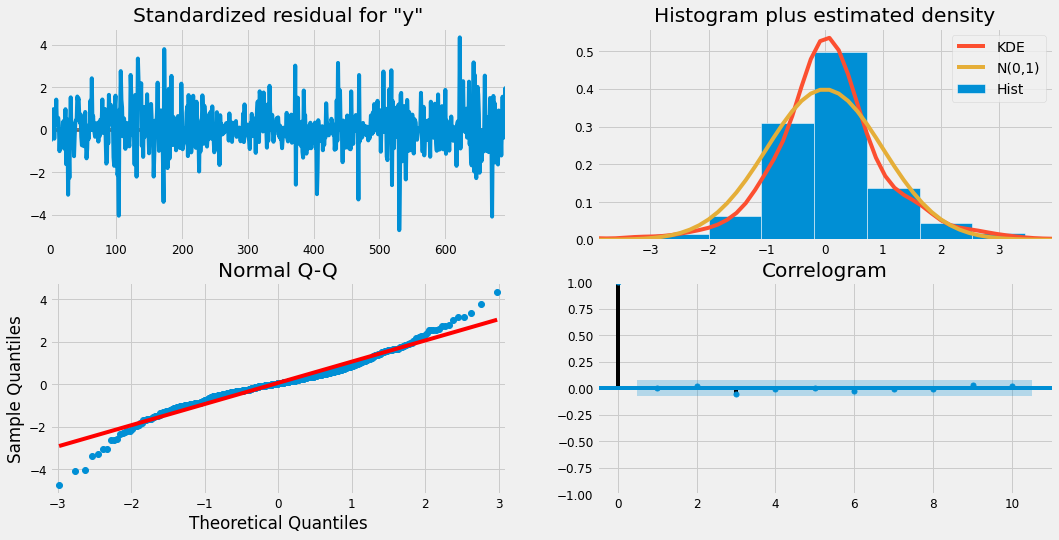

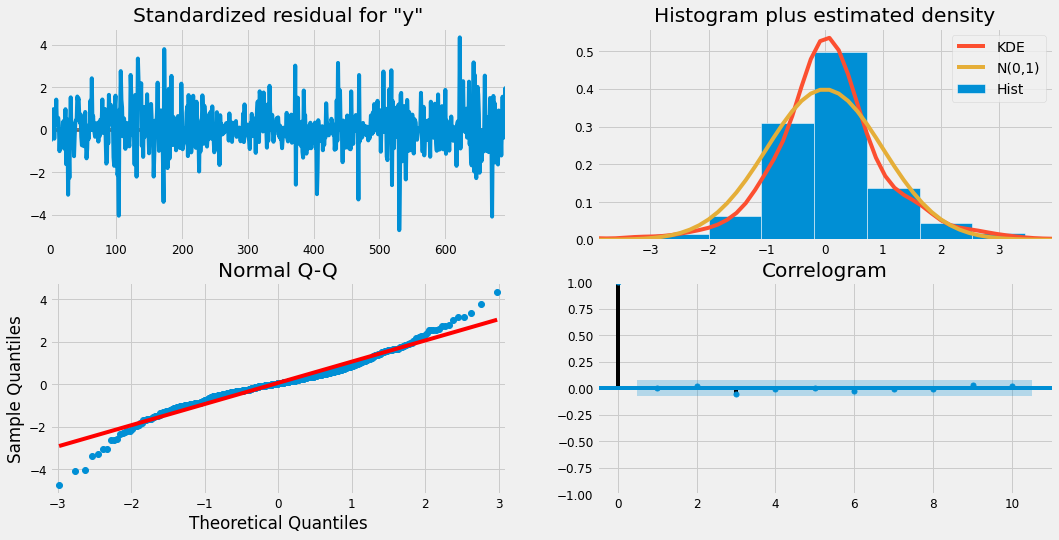

In [ ]:
model_aic.plot_diagnostics(figsize=(16,8))

In [ ]:
forecast = model_aic.get_prediction(periods=len(test)-2)
predictions = forecast.predicted_mean

In [ ]:
predictions

Date
2015-01-05     0.000000
2015-01-06    -0.854132
2015-01-07    -4.163930
2015-01-08    -0.469059
2015-01-09    -6.054952
                ...    
2017-12-25    -4.287687
2017-12-26    13.289712
2017-12-27     2.033811
2017-12-28     3.179559
2017-12-29    -8.049639
Name: predicted_mean, Length: 744, dtype: float64

In [ ]:
model_aic.forecast()

744   -8.96994
dtype: float64

In [ ]:
forecast = model_aic.forecast(steps= 22)
forecast

744    -8.969940
745    -7.664202
746   -11.714090
747     3.025723
748    10.492107
749    24.714595
750    15.669783
751    -3.690028
752    18.440380
753     4.824220
754     6.648673
755    -3.881910
756    -0.680938
757    -2.783918
758    -9.732726
759     4.743398
760    11.813806
761    25.930788
762    16.543373
763    -3.869358
764    18.856568
765     4.954497
Name: predicted_mean, dtype: float64

In [ ]:
temp = data['Adj Close']
temp = temp[744:766]
temp

Date
2017-12-29    4122.659180
2018-01-01    4122.659180
2018-01-02    4122.659180
2018-01-03    4122.659180
2018-01-04    4183.839844
2018-01-05    4188.546387
2018-01-08    4207.370605
2018-01-09    4240.313965
2018-01-10    4226.196289
2018-01-11    4273.257324
2018-01-12    4221.489258
2018-01-15    4230.902344
2018-01-16    4254.433594
2018-01-17    4169.721191
2018-01-18    4249.727539
2018-01-19    4226.196289
2018-01-22    4230.902344
2018-01-23    4263.845703
2018-01-24    4249.727539
2018-01-25    4249.727539
2018-01-26    4273.257324
2018-01-29    4292.082520
Name: Adj Close, dtype: float64

In [ ]:
temp_train = data['Adj Close']
temp_train = temp_train[:744]
temp_train

Date
2015-01-02    2403.688232
2015-01-05    2399.144287
2015-01-06    2380.968994
2015-01-07    2385.513184
2015-01-08    2358.250000
                 ...     
2017-12-22    4047.359375
2017-12-25    4047.359375
2017-12-26    4047.359375
2017-12-27    4052.065186
2017-12-28    4127.364746
Name: Adj Close, Length: 744, dtype: float64

In [ ]:
train_undiff = predictions + temp_train
train_undiff = train_undiff[1:744]
train_undiff

Date
2015-01-05    2399.144287
2015-01-06    2380.114862
2015-01-07    2381.349254
2015-01-08    2357.780941
2015-01-09    2343.106913
                 ...     
2017-12-22    4065.282657
2017-12-25    4043.071688
2017-12-26    4060.649087
2017-12-27    4054.098997
2017-12-28    4130.544305
Length: 743, dtype: float64

In [ ]:
forecast_undiff = pd.read_csv('/content/BBCA UNDIFF.csv')

In [ ]:

print('The Rsquare of forecast is',r2_score(list(temp_train[2:]), list(train_undiff[1:744])))
print('The Rsquare of forecast is',r2_score(list(forecast_undiff['y']), list(forecast_undiff['Hasil'])))

The Rsquare of forecast is 0.9986466083940977
The Rsquare of forecast is 0.5322560847503898
